## 1.0  Data Import and Analysis

In [1]:
import numpy as np
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
fake_df = pd.read_csv('/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv')

In [3]:
fake_df['label'] = 1
true_df['label'] = 0

In [4]:
fake_df.head(2)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1


In [5]:
true_df.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


In [6]:
news_df = pd.concat([true_df, fake_df], ignore_index=True)

In [7]:
news_df.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


# About the Dataset:

id: unique id for a news article                                     
title: the title of a news article                                  
author: author of the news article                                    
text: the text of the article; could be incomplete                                        
label: a label that marks whether the news article is real or fake:                              
    1: Fake news                                                 
    0: real News                                        

## 1.1 Preprocessing 

In [8]:
news_df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [9]:
news_df.shape

(44898, 5)

In [10]:
news_df = news_df.fillna(' ')

In [11]:
news_df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [12]:
news_df = news_df.drop(['title', 'subject', 'date'], axis=1)
news_df.head(2)

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0


In [13]:
news_df['text'][455]

'LONDON (Reuters) - British Prime Minister Theresa May is fully focused on tackling extremism, her spokesman said on Thursday, responding to a tweet by U.S. President Donald Trump telling her to focus on “destructive Radical Islamic Terrorism”. Asked if May was focused on tackling extremism: her spokesman said: “Yes.”  “The overwhelming majority of Muslims in this country are law-abiding people who abhor extremism in all its forms. The prime minister has been clear ... that where Islamist extremism does exist it should be tackled head on. We are working hard to do that both at home and internationally and ... with our U.S. partners.” '

In [14]:
news_df.shape

(44898, 2)

### Slice The Dataset

In [15]:
df = news_df[17000:25000]
df = df.reset_index(drop=True)
df.shape

(8000, 2)

### Without slicing the dataset

In [16]:
df = news_df.copy()
df.shape

(44898, 2)

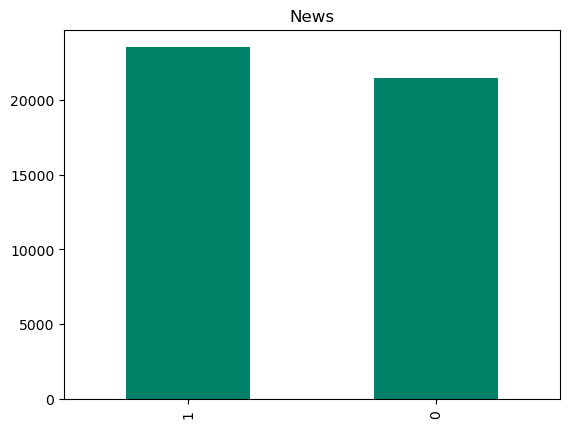

In [17]:
 df.label.value_counts().plot(kind='bar', cmap='summer', title='News');

In [18]:
df.head(2)

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0


In [19]:

df['text'][455]

'LONDON (Reuters) - British Prime Minister Theresa May is fully focused on tackling extremism, her spokesman said on Thursday, responding to a tweet by U.S. President Donald Trump telling her to focus on “destructive Radical Islamic Terrorism”. Asked if May was focused on tackling extremism: her spokesman said: “Yes.”  “The overwhelming majority of Muslims in this country are law-abiding people who abhor extremism in all its forms. The prime minister has been clear ... that where Islamist extremism does exist it should be tackled head on. We are working hard to do that both at home and internationally and ... with our U.S. partners.” '

In [20]:
def clean_text(test):
    '''
    Clean's up the unnecessary thiings of a text by replacing them with proper symbols.
    '''
    test = test.replace('<br/>', '')
    test = test.replace('--', ' ')
    test = test.replace("'", '')
    test = test.replace('"','')
#     test = test.replace('.', '')
    test = test.replace(',', '')
#     test = test.replace('?', '')
#     test = test.replace('!', '')
    test = test.replace('\n', '')
    test = test.replace('(', '')
    test = test.replace(')', '')
    test = test.lower()
    test = test.replace('</li></ul><ul><li>', ' ')
    test = test.replace('< ul><li >', ' ')
    test = test.replace('< /li></ul >', ' ')
    test = test.replace('</li><li >', ' ')
    test = test.replace('< /li><li >', ' ')
    test = ' '.join(filter(None, test.split()))
     
    return test

In [21]:
df.text = df.text.apply(clean_text)

## 2.0 Data Division

In [22]:
from sklearn.model_selection import train_test_split 

np.random.seed(71)
train, temp = train_test_split(df, test_size=0.3)
valid, test = train_test_split(temp, test_size=.5)
len(train), len(test), len(valid)

(31428, 6735, 6735)

In [23]:
train.head(2)

,text,label
6790,washington reuters - a bill to fund the u.s. g...,0
8291,moscow reuters - russian president vladimir pu...,0


In [24]:
from datasets import Dataset,DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train),
    "validation": Dataset.from_pandas(valid)
    })

In [25]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 31428
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 6735
    })
})

## 2.1 Fine Tuned `BERT` Model 

In [26]:
from transformers import BertTokenizer, TFBertModel,AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True,padding=True)

tokenized_data = dataset.map(preprocess_function, batched=True)

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [27]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 31428
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6735
    })
})

In [28]:
from transformers import DataCollatorWithPadding
#import evaluate
#accuracy=evaluate.load("accuracy")
data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

In [29]:
def compute_metrics(eval_pred):
  predictions,labels=eval_pred
  predictions=np.argmax(predictions,axis=1)
  return accuracy.compute(predictions=predictions,refernces=labels)

In [30]:
id2label = {0:0,1:1}
label2id = {0:0,1:1}

from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs = 5
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [31]:
from transformers import TFAutoModelForSequenceClassification
model=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [32]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


tf_validation_set = model.prepare_tf_dataset(
    tokenized_data["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [33]:
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


In [34]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 0,
    "1": 1
  },
  "initializer_range": 0.02,
  "label2id": {
    "0": 0,
    "1": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

In [35]:
history = model.fit(x=tf_train_set,validation_data=tf_validation_set, epochs = num_epochs)

Epoch 1/5
1964/1964 [==============================] - 1974s 992ms/step - loss: 0.0108 - accuracy: 0.9973 - val_loss: 0.0022 - val_accuracy: 0.9996
Epoch 2/5
1964/1964 [==============================] - 1953s 994ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 3/5
1964/1964 [==============================] - 1953s 994ms/step - loss: 5.8740e-04 - accuracy: 0.9999 - val_loss: 0.0041 - val_accuracy: 0.9996
Epoch 4/5
1964/1964 [==============================] - 1952s 994ms/step - loss: 4.9444e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 5/5
1964/1964 [==============================] - 1949s 992ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0018 - val_accuracy: 0.9999


In [36]:
# Get the training and validation accuracy from the history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_acc = [round(acc, 4) for acc in train_acc]
print(f'train = {train_acc}\n')
val_acc = [round(acc, 4) for acc in val_acc]
print(f'validation = {val_acc}')

train = [0.9973, 0.9998, 0.9999, 0.9999, 0.9996]

validation = [0.9996, 0.9997, 0.9996, 0.9997, 0.9999]


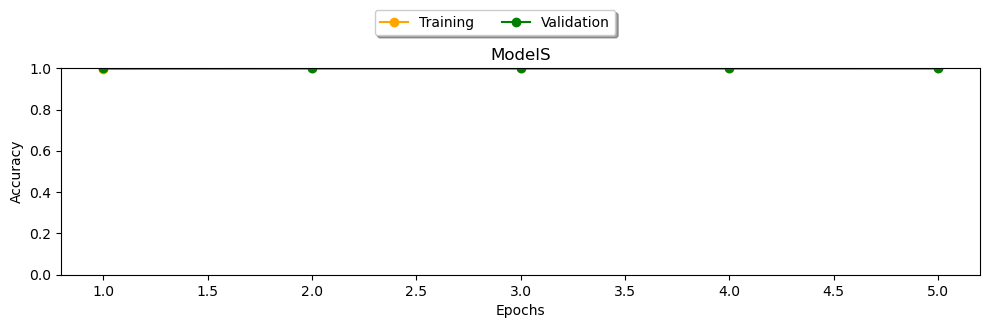

In [37]:
import matplotlib.pyplot as plt
# # Example data
epochs = [i for i in range(1, num_epochs+1)]
#jk
train_loss_1 = train_acc
val_loss_1 = val_acc

# Create three subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 3))

# Plot for Model 1
axes.plot(epochs, train_loss_1, label='Training Loss',color='orange', linestyle='-', 
             marker='o')
axes.plot(epochs, val_loss_1, label='Validation Loss', color='green', linestyle='-', 
             marker='o')
axes.set_xlabel('Epochs')
axes.set_ylabel('Accuracy')
axes.set_title('ModelS')
axes.set_ylim([0, 1])

# Add legend at the top
legend_labels = ['Training', 'Validation']
fig.legend(legend_labels, loc='upper center', 
           bbox_to_anchor=(0.5, 1.10), ncol=2, fancybox=True, shadow=True)



# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## 3. Evaluation

In [38]:
def custom_test(text, max_seq_length=512):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, max_length=max_seq_length, padding=True)
    
    # Check if the input sequence was truncated
    if len(inputs.input_ids[0]) > max_seq_length:
        print("Warning: Input sequence was truncated.")
    
    # Perform the prediction
    tf_outputs = model(**inputs)
    logits = tf_outputs.logits
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    return predicted_class_id


In [39]:
test.head(2)

,text,label
36765,it s time to stop hitting the snooze button am...,1
23110,how bad is trump for the gop? it seems he s wo...,1


In [40]:
test_text = test['text']
test_text.head(3)

36765    it s time to stop hitting the snooze button am...
23110    how bad is trump for the gop? it seems he s wo...
20660    new delhi reuters - india has issued new norms...
Name: text, dtype: object

In [41]:
y_true = test['label'].values
y_true [:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0])

In [42]:
test.head(2)

,text,label
36765,it s time to stop hitting the snooze button am...,1
23110,how bad is trump for the gop? it seems he s wo...,1


In [43]:
from tqdm import tqdm
y_pred = []
for text in tqdm(test_text):
    try:
        ans = custom_test(text)
        y_pred.append(ans)
    except:
        y_pred.append(0)
y_pred[:10]

100%|██████████| 6735/6735 [11:04<00:00, 10.13it/s]


[1, 1, 0, 0, 1, 1, 1, 1, 0, 0]

## 3.1 Confusion Matrix

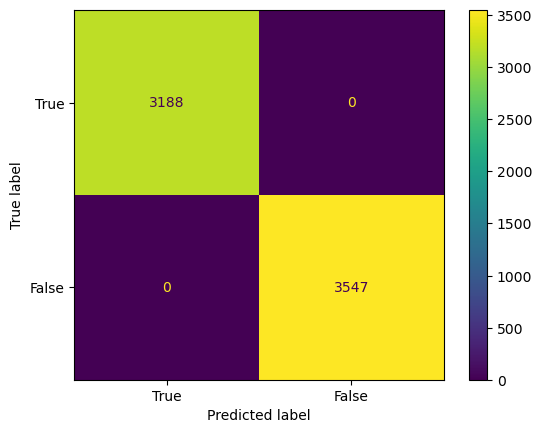

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'False'])

cm_display.plot()
plt.show()

In [45]:
rand_index = np.random.randint(0,1000)
text = news_df['text'][rand_index]
print(text)
custom_test(text)

GADSDEN, Ala. (Reuters) - In a U.S. Senate race rocked by allegations of sexual misconduct against Republican candidate Roy Moore, some women in his hometown said they were sticking by the embattled nominee while others said prayer would guide their votes on Tuesday. Caroll Norman, a retired middle school teacher in Gadsden, said she did not know if she would vote for a Democrat for the first time in her life or write in another name on her ballot. Perusing a candle shop downtown Monday evening, the Trump supporter said not even the president’s vocal backing of the embattled Republican nominee had swayed her. “I’ll have to pray about it and make a decision in the morning,” the 64-year-old Republican said. Reuters spoke to more than a dozen women in the religious, working-class city of about 36,000 people an hour from Birmingham. Gadsden landed in an unwelcome spotlight after multiple women came forward last month to accuse Moore of pursuing them when they were teenagers and he was a lo

0

## 3.2 Accuracy Score

In [46]:
from sklearn.metrics import accuracy_score
print(f'Accuracy = {accuracy_score(y_true,y_pred) * 100}%')

Accuracy = 100.0%


## 3.3 ROC Curve

In [47]:
def final(text):
    '''
    Implements our awsome algorithm and gives final output
    '''
    inputs=tokenizer(text,return_tensors="tf", truncation=True)
    x = []
    tf_outputs = model(inputs)                                  
    tf_predictions_final = tf.nn.softmax(tf_outputs[0], axis=-1)  
    x.append(tf_predictions_final.numpy().flatten())
    return x

In [48]:
test = test.reset_index(drop=True)
test.head(2)

,text,label
0,it s time to stop hitting the snooze button am...,1
1,how bad is trump for the gop? it seems he s wo...,1


In [49]:
final(test['text'][0])

[array([1.0804105e-05, 9.9998915e-01], dtype=float32)]

In [50]:
test_text = test['text']
test_text.head(3)

0    it s time to stop hitting the snooze button am...
1    how bad is trump for the gop? it seems he s wo...
2    new delhi reuters - india has issued new norms...
Name: text, dtype: object

In [51]:
predict = []
for text in tqdm(test_text):
    re = final(text)
    ans = []
    for val in re:
        for v in val:
            ans.append(v)
    np_array = np.array(ans)
    np_array = np_array.tolist()
    predict.append(np_array)

100%|██████████| 6735/6735 [11:04<00:00, 10.13it/s]


In [52]:
predict = np.array(predict)
predict[:10]

array([[1.08041049e-05, 9.99989152e-01],
       [9.69859411e-06, 9.99990344e-01],
       [9.99882936e-01, 1.17088937e-04],
       [9.99881983e-01, 1.18008742e-04],
       [1.01389405e-05, 9.99989867e-01],
       [8.31396937e-06, 9.99991655e-01],
       [1.08874510e-05, 9.99989152e-01],
       [1.28543415e-05, 9.99987125e-01],
       [9.99875426e-01, 1.24533020e-04],
       [9.99876380e-01, 1.23601596e-04]])

In [53]:
test.head(10)

,text,label
0,it s time to stop hitting the snooze button am...,1
1,how bad is trump for the gop? it seems he s wo...,1
2,new delhi reuters - india has issued new norms...,0
3,budapest reuters - the european union should s...,0
4,the explosion of a nuclear missile in the hear...,1
5,in your face progressivism they re not even at...,1
6,and here we thought terrorism was the only thi...,1
7,bill hemmer let mitch mcconnell have it but mc...,1
8,washington reuters - u.s. democratic senator a...,0
9,berlin reuters - disputes about climate and im...,0


In [54]:
true = test['label'].values
true = np.array(true)

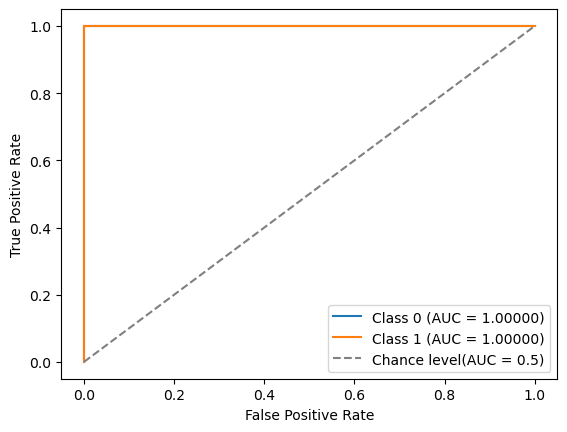

In [55]:
from sklearn.metrics import roc_curve, auc
# Calculate the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(true == i, predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance level(AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Multi-Class ROC Curv')
plt.legend(loc='lower right')
plt.show()

## 3.4 Classification Report

In [56]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, output_dict=True)

cr_df = pd.DataFrame(report).transpose()
cr_df = cr_df.round(2)
cr_df

,precision,recall,f1-score,support
0,1.0,1.0,1.0,3188.0
1,1.0,1.0,1.0,3547.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,6735.0
weighted avg,1.0,1.0,1.0,6735.0


## Ending BERT section

## For Machine Learning Model

In [57]:
# Import all the tools we need


# Regular EDA(exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

## 4.1`Data Preprocessing`

In [58]:

def stop_words(doc):
    '''
    Removes Words that are not that necessary for our model.
    '''
    # Process the document
    doc = nlp(doc)

    # List of stop words in spaCy
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Filter out stop words from the document
    filtered_words = [token.text for token in doc if not token.is_stop]

    # Join the filtered words back into a string
    filtered_document = " ".join(filtered_words)
    
    return filtered_document


import spacy

# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_lg")


# Function to convert text to vectors using spaCy
def text_to_vectors(text):
    '''
    Converts text to vector
    '''
    doc = nlp(text)
    return doc.vector


In [59]:
# df = news_df[21000:22000]
# df = df.reset_index(drop=True)
# df.shape

In [60]:
df = news_df.copy()
df.shape

(44898, 2)

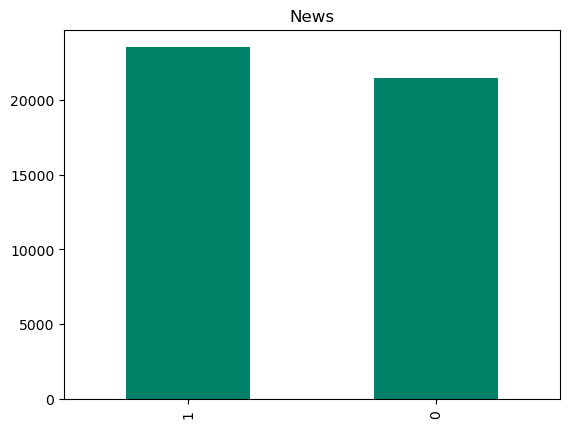

In [61]:
 df.label.value_counts().plot(kind='bar', cmap='summer', title='News');

In [62]:
news_df.shape

(44898, 2)

In [63]:
tqdm.pandas(desc="Processing...")
df.text = df.text.progress_apply(clean_text)
# news_df['text'] = news_df['text'].progress_apply(stop_words)


Processing...: 100%|██████████| 44898/44898 [00:03<00:00, 12381.25it/s]


## 4.2 Make Vectors from text 

In [64]:
df['vector'] = df['text'].progress_apply(text_to_vectors)

Processing...: 100%|██████████| 44898/44898 [48:00<00:00, 15.58it/s]


In [65]:
df.head(3)

,text,label,vector
0,washington reuters - the head of a conservativ...,0,"[-1.964682, 0.9707499, -3.012769, 0.39993116, ..."
1,washington reuters - transgender people will b...,0,"[-1.7856287, 1.4982328, -2.3078003, 0.4470384,..."
2,washington reuters - the special counsel inves...,0,"[-1.258385, 1.063325, -2.2178643, 0.42279693, ..."


## 5.1 Data Division

In [66]:
from sklearn.model_selection import train_test_split
# Set data 
X = list(df['vector'])
y = list(df.label.astype(int))
# Split the data into training and testing sets

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test), len(y_train), len(y_test)

(35918, 8980, 35918, 8980)

## 6.1 Model Training

## 6.2 Logostic Regression

In [67]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create and train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

#Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}", )

Accuracy: 98.88


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


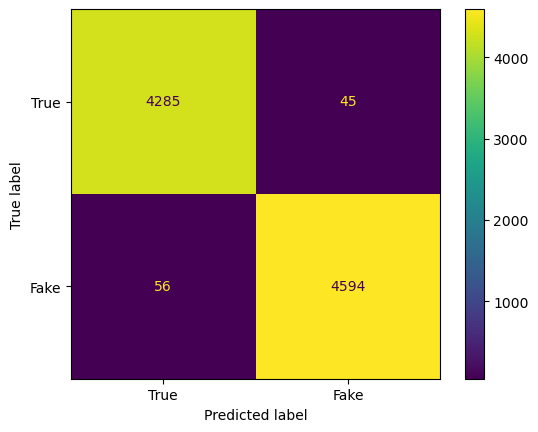

Accuracy: 98.88 %


In [68]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'Fake'])

cm_display.plot()
plt.show()

print(f"Accuracy: {accuracy*100:.2f} %", )

In [69]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)

cr_df = pd.DataFrame(report).transpose()
cr_df = cr_df.round(2)
cr_df

,precision,recall,f1-score,support
0,0.99,0.99,0.99,4330.00
1,0.99,0.99,0.99,4650.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,8980.00
weighted avg,0.99,0.99,0.99,8980.00


## 6.3 XGBoost CLasifier

In [70]:
# Import XGBoost
from xgboost import XGBClassifier

# Create and train the XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Calculate accuracy score
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
XGBoost Accuracy: 98.91


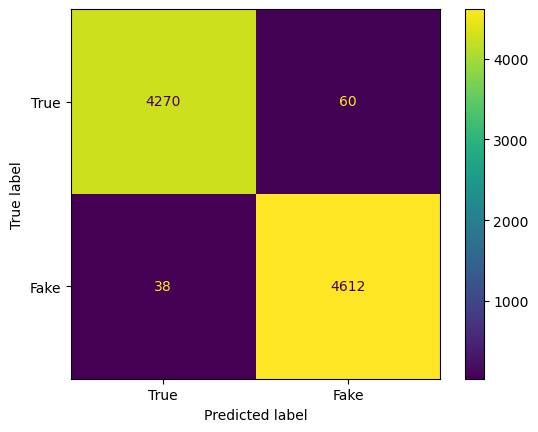

Accuracy: 98.91 %


In [71]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'Fake'])

cm_display.plot()
plt.show()

print(f"Accuracy: {accuracy_xgb*100:.2f} %", )

In [72]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_xgb, output_dict=True)

cr_df = pd.DataFrame(report).transpose()
cr_df = cr_df.round(2)
cr_df

,precision,recall,f1-score,support
0,0.99,0.99,0.99,4330.00
1,0.99,0.99,0.99,4650.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,8980.00
weighted avg,0.99,0.99,0.99,8980.00


## 6.4 Cat Boost Classifier

In [73]:
from IPython.display import clear_output
# Import CatBoost
from catboost import CatBoostClassifier

# Create and train the CatBoost model
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train)

# Make predictions
y_pred_catboost = catboost.predict(X_test)

# Calculate accuracy score
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)


clear_output()


In [74]:
print(f"CatBoost Accuracy: {accuracy_catboost * 100:.2f}")

CatBoost Accuracy: 99.27


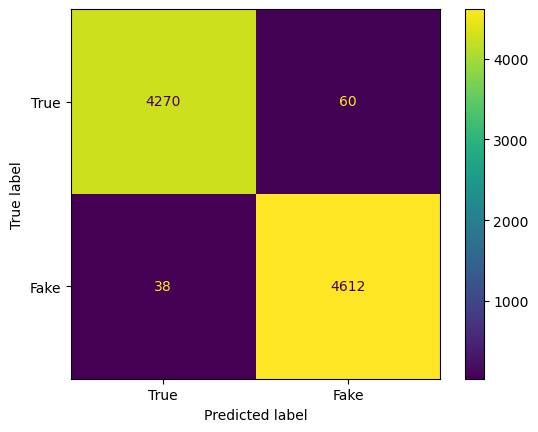

Accuracy: 99.27 %


In [75]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'Fake'])

cm_display.plot()
plt.show()

print(f"Accuracy: {accuracy_catboost*100:.2f} %", )

In [76]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_catboost, output_dict=True)

cr_df = pd.DataFrame(report).transpose()
cr_df = cr_df.round(3)
cr_df

,precision,recall,f1-score,support
0,0.995,0.990,0.992,4330.000
1,0.991,0.995,0.993,4650.000
accuracy,0.993,0.993,0.993,0.993
macro avg,0.993,0.993,0.993,8980.000
weighted avg,0.993,0.993,0.993,8980.000


## 6.5 Random Forest Classifier

In [77]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest Classifier model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Make predictions
y_pred_rfc = rfc.predict(X_test)

# Calculate accuracy score
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)

print(f"Random Forest Accuracy: {accuracy_rfc * 100:.2f}")


Random Forest Accuracy: 97.94


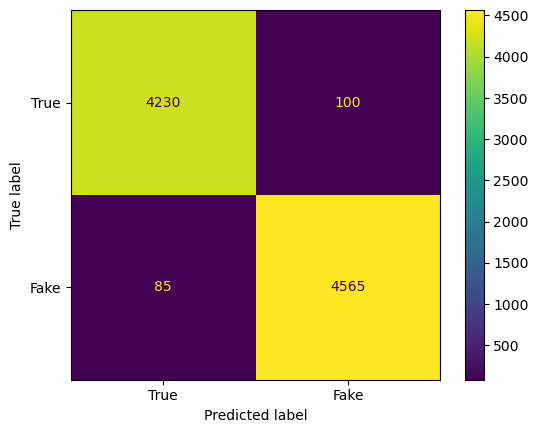

Accuracy: 97.94 %


In [78]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rfc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['True', 'Fake'])

cm_display.plot()
plt.show()

print(f"Accuracy: {accuracy_rfc*100:.2f} %", )

In [79]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_rfc, output_dict=True)

cr_df = pd.DataFrame(report).transpose()
cr_df = cr_df.round(3)
cr_df

,precision,recall,f1-score,support
0,0.980,0.977,0.979,4330.000
1,0.979,0.982,0.980,4650.000
accuracy,0.979,0.979,0.979,0.979
macro avg,0.979,0.979,0.979,8980.000
weighted avg,0.979,0.979,0.979,8980.000


## Author : `Faria Efa`